---
title: OSI - Oil Spill Index
subtitle: Learn how to use the Oil Spill Index (OSI) to detect oil spills using Sentine-2 data.
authors:
  - name: Juraj Zvolenský
    orcid: 0009-0000-9185-7955
    github: jzvolensky
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-08-28
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: ["earth observation", "remote sensing"]
tags: ["template"]
releaseDate: 2025-08-28
datePublished: 2025-08-28
dateModified: 2025-08-28
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Create Datacube](#Create-Datacube)
- [Spatial and temporal filtering](#Spatial-and-temporal-filtering)
- [Cloud masking](#cloud-masking)
- [Visualize masked data for one date](#visualize-masked-data-for-one-date)
- [Compute OSI](#Compute-OSI)
- [Visualize results](#Visualize-results)

(Introduction-OIL)=
## Introduction

The OSI (Oil Spill Index) uses visible Sentinel-2 bands to display oil spills over water in the costal/marine environment. The OSI is constructed by summing-up the bands representing the shoulders of absorption features of oil as numerator and the band located nearest to the absorption feature as denominator to discriminate oil spill as below.

OSI = (B03 + B04) / B02

The original idea was created by Sankaran Rajendran and is available in the Sentinel Hub documentation [here](https://custom-scripts.sentinel-hub.com/sentinel-2/oil-spill-index/).

## MV Wakashio oil spill

<a data-flickr-embed="true" href="https://www.flickr.com/photos/imo-un/50237761237/in/photostream/" title="IMO helping to mitigate the impacts of MV Wakashio oil spill in Mauritius"><img src="https://live.staticflickr.com/65535/50237761237_b2d6d9e131_b.jpg" width="1024" height="682" alt="IMO helping to mitigate the impacts of MV Wakashio oil spill in Mauritius"/></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>

Source: International Maritime Organization 2020 [link](https://flic.kr/p/2jxkEac)

This notebook demonstrates the application of the Oil Spill Index (OSI) to the MV Wakashio oil spill incident in Mauritius using Sentinel-2 imagery.

The incident occured in July 2020 when a Japanese ship ran aground on a coral reef and started leaking fuel oil into the surrounding area for several days.

MV Wakashio was 300 meters long and at the time was carrying roughly 4000 tons of very low sulfur fuel oil (VLSFO). High winds and waves made the cleanup process very difficult. 

More information on the oil spill can be found here:

- [United Nations Office for the Coordination of Humanitarian Affairs (OCHA) - Oil Spill in Mauritius](https://www.unocha.org/publications/report/mauritius/mauritius-mw-wakashio-oil-spill-flash-update-no-1-8-august-2020)

:::{hint} Overview
**Questions**
- How to access Sentinel-2 Zarr data?
- How to calculate the OSI (Oil Spill Index) using Sentinel-2 data?
- Why is it useful?

**Objectives**
- Access Sentinel-2 Zarr data.
- Calculate the OSI (Oil Spill Index) using Sentinel-2 data.
- Understand the usefulness of the OSI for detecting oil spills.
- Learn how to visualize the OSI results.
:::

(Setup-OIL)=
## Setup
Start importing the necessary libraries

In [30]:
import xarray as xr
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
from pystac_client import CollectionSearch

from shapely import geometry

from distributed import LocalCluster

In [31]:
cluster = LocalCluster(processes=False)
client = cluster.get_client()
cluster

/home/jzvolensky/miniconda3/envs/eopf-zarr/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38627 instead
  warnings.warn(


LocalCluster(64d24493, 'inproc://10.8.244.70/1251659/19', workers=1, threads=4, memory=31.34 GiB)

/home/jzvolensky/miniconda3/envs/eopf-zarr/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


(Stac-search-OIL)=
## STAC search

In [32]:
search = CollectionSearch(
    url="https://stac.core.eopf.eodc.eu/collections",
)
for collection_dict in search.collections_as_dicts():
    print(collection_dict["id"])

sentinel-2-l2a
sentinel-3-slstr-l2-lst
sentinel-3-olci-l2-lfr
sentinel-2-l1c
sentinel-3-slstr-l1-rbt
sentinel-3-olci-l1-efr
sentinel-3-olci-l1-err
sentinel-1-l1-slc
sentinel-1-l1-grd
sentinel-1-l2-ocn
sentinel-3-olci-l2-lrr


In [33]:
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
items = list(
    catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=[57.684646751857144, -20.466450832612153, 57.78531132251502, -20.3794154117235],
        datetime=["2020-06-30", "2020-10-01"],
    ).items()
)
print(f"items found: {len(items)}")

dates = [
    datetime(2020, 7, 17),
    datetime(2020, 8, 1),
    datetime(2020, 8, 6),
    datetime(2020, 9, 5),
]

date_set = {d.date() for d in dates}

items = [i for i in items if i.datetime.date() in date_set]
print(f"Selected items: {len(items)}")

items found: 19
Selected items: 4


In [34]:
items

[<Item id=S02MSIL2A_20200905T062449_0000_B091_T778>,
 <Item id=S02MSIL2A_20200806T062449_0000_B091_T103>,
 <Item id=S02MSIL2A_20200801T062451_0000_A091_T114>,
 <Item id=S02MSIL2A_20200717T062449_0000_B091_T774>]

(create-datacube-OIL)=

## Create Datacube

In the following section we extract the `20 meter bands` as well as the `scene classification layer (scl)` from the Sentinel-2 data.

These variables are then merged into a single datacube

In [35]:
datasets = []
for item in items:
    href = item.assets["product"].href

    ds = xr.open_datatree(
        href,
        engine="zarr",
        chunks={},          
        mask_and_scale=True
    )

    ds_ref = ds["measurements"]["reflectance"]["r20m"].ds  

    ds_ref = ds_ref.assign_coords(time=item.datetime).expand_dims("time")
    datasets.append(ds_ref)

r20m = xr.concat(datasets, dim="time")

scl_datasets = []

for item in items:
    href = item.assets["product"].href

    ds = xr.open_datatree(
        href,
        engine="zarr",
        chunks={},          
        mask_and_scale=True
    )

    ds_scl = ds["conditions"]["mask"]["l2a_classification"]["r20m"].ds  

    ds_scl = ds_scl.assign_coords(time=item.datetime).expand_dims("time")
    scl_datasets.append(ds_scl)


scl_cube = xr.concat(scl_datasets, dim="time")

datacube = xr.merge([r20m, scl_cube])
datacube = datacube.sortby("time")

datacube

<xarray.Dataset> Size: 11GB
Dimensions:  (time: 4, y: 5490, x: 5490)
Coordinates:
  * x        (x) float32 22kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y        (y) float32 22kB 7.8e+06 7.8e+06 7.8e+06 ... 7.69e+06 7.69e+06
  * time     (time) object 32B 2020-07-17 06:24:49.024000+00:00 ... 2020-09-0...
Data variables:
    b01      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b02      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b03      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b04      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b05      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b06      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b07      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b11      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b12      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b8a      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    scl      (time, y, x) float64 964MB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

(Spatial-and-temporal-filtering-OIL)=
## Spatial and temporal filtering

In [36]:
epsg_code = items[0].properties.get("proj:code")

def spatial_filter(ds: xr.DataArray, bbox: list, epsg: int = 32740):
    x_slice = slice(bbox[0], bbox[2])
    y_slice = slice(bbox[3], bbox[1])
    bbox_polygon = geometry.box(*bbox)
    polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[bbox_polygon])
    bbox_reproj = polygon.to_crs("epsg:" + str(epsg)).geometry.values[0].bounds
    x_slice = slice(bbox_reproj[0], bbox_reproj[2])
    y_slice = slice(bbox_reproj[3], bbox_reproj[1])
    return ds.sel(x=x_slice, y=y_slice)


def temporal_filter(ds: xr.DataArray, date):
    return ds.sel(time=date, method="nearest")


dates = [
    "2020-07-17",
    "2020-08-01",
    "2020-08-06",
    "2020-09-05"
]

bbox = [57.684646751857144, -20.466450832612153, 57.78531132251502, -20.3794154117235]

datasets = []

for date in dates:
    ds_spatial = spatial_filter(datacube, bbox)
    ds_temporal = temporal_filter(ds_spatial, date)
    datasets.append(ds_temporal)

datasets[0]

<xarray.Dataset> Size: 22MB
Dimensions:  (y: 484, x: 528)
Coordinates:
  * x        (x) float32 2kB 5.714e+05 5.714e+05 ... 5.819e+05 5.82e+05
  * y        (y) float32 2kB 7.746e+06 7.746e+06 ... 7.737e+06 7.737e+06
    time     datetime64[ns] 8B 2020-07-17T06:24:49.024000
Data variables:
    b01      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b02      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b03      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b04      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b05      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b06      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b07      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b11      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b12      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b8a      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    scl      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>

(cloud-masking-OIL)=
## Cloud masking

In [37]:
scl_masks = []

for date in dates:
    ds_spatial = spatial_filter(datacube["scl"], bbox)
    ds_temporal = temporal_filter(ds_spatial, date)
    scl_masks.append(ds_temporal)

scl_masks[0]

<xarray.DataArray 'scl' (y: 484, x: 528)> Size: 2MB
dask.array<getitem, shape=(484, 528), dtype=float64, chunksize=(422, 439), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 2kB 5.714e+05 5.714e+05 ... 5.819e+05 5.82e+05
  * y        (y) float32 2kB 7.746e+06 7.746e+06 ... 7.737e+06 7.737e+06
    time     datetime64[ns] 8B 2020-07-17T06:24:49.024000
Attributes:
    _eopf_attrs:  {'add_offset': 0, 'coordinates': ['y', 'x'], 'dimensions': ...
    dtype:        <u1
    long_name:    scene classification map at 20m

In [38]:
masked_datasets = []

for ds in datasets:

    scl = ds["scl"]

    cloud_mask = ~scl.isin([3, 8, 9, 10])

    bands = [v for v in ds.data_vars if v != "scl"]
    ds_masked = ds[bands].where(cloud_mask)

    masked_datasets.append(ds_masked)

masked_datasets[0]

<xarray.Dataset> Size: 20MB
Dimensions:  (y: 484, x: 528)
Coordinates:
  * x        (x) float32 2kB 5.714e+05 5.714e+05 ... 5.819e+05 5.82e+05
  * y        (y) float32 2kB 7.746e+06 7.746e+06 ... 7.737e+06 7.737e+06
    time     datetime64[ns] 8B 2020-07-17T06:24:49.024000
Data variables:
    b01      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b02      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b03      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b04      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b05      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b06      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b07      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b11      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b12      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b8a      (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>

(Visualize-masked-data-for-one-date-OIL)=
## Visualize masked data for one date

The following visualization shows the area of interest before the oilspill event. 

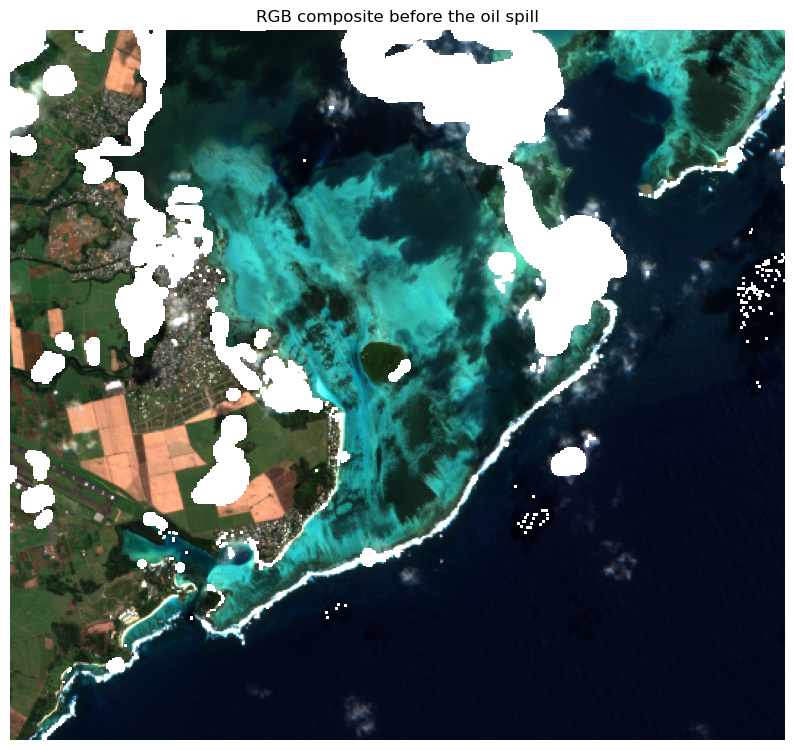

In [39]:
def compute_rgb(dataset):
    b02 = dataset["b02"]
    b03 = dataset["b03"]
    b04 = dataset["b04"]

    rgb = np.stack([b04, b03, b02], axis=-1)

    rgb = (rgb / 0.25).clip(0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb, origin="upper")
    plt.title("RGB composite before the oil spill")
    plt.axis("off")
    plt.show()


ds = masked_datasets[0]
compute_rgb(ds)

(Compute-OSI-OIL)=
## Compute OSI

The standard way of computing OSI is (B03 + B04) / B02.

However, there are several other variants that can be used to compute the OSI, taking advantage of different spectral bands. These variants may provide additional insights or improve the sensitivity of the index to oil spills:


`R: (B05+ B06)/ B07; G: (B03+ B04)/B02; B: (B011+ B012)/ B08`

`R: B03/ B02; G: (B03+ B04)/B02; B: (B06+ B07)/ B05`

`Zakzouk, M., Abou El-Magd, I., Ali, E. M., Abdulaziz, A. M., Rehman, A., & Saba, T. (2024). Novel oil spill indices for sentinel-2 imagery: A case study of natural seepage in Qaruh Island, Kuwait. MethodsX, 12, 102520.`


In this example we compute all variants and visualize them below

In [43]:
import matplotlib.patches as patches


def compute_osi_variants(dataset, highlight_box=None):
    b02 = dataset["b02"]
    b03 = dataset["b03"]
    b04 = dataset["b04"]
    b05 = dataset["b05"]
    b06 = dataset["b06"]
    b07 = dataset["b07"]
    b08 = dataset["b8a"]
    b11 = dataset["b11"]
    b12 = dataset["b12"]

    osi_variants = {}

    # Variant 1: (B04 + B03) / B02
    osi_variants["OSI_1_(B04+B03)/B02"] = (b04 + b03) / b02

    # Variant 2
    R = (b05 + b06) / b07
    G = (b03 + b04) / b02
    B = (b11 + b12) / b08
    osi_variants["OSI_2_((B05+B06)/B07 + (B03+B04)/B02) / ((B11+B12)/B08)"] = (
        R + G
    ) / B

    # Variant 3
    R = b03 / b02
    G = (b03 + b04) / b02
    B = (b06 + b07) / b05
    osi_variants["OSI_3_((B03/B02 + (B03+B04)/B02) / ((B06+B07)/B05))"] = (R + G) / B

    rgb = np.stack([b04, b03, b02], axis=-1).astype(float)
    rgb = (rgb / 0.25).clip(0, 1)  # simple linear stretch

    # Combine RGB + OSI variants for plotting
    n = len(osi_variants) + 1
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
    if n == 1:
        axes = [axes]

    # Add red box
    def add_highlight(ax):
        if highlight_box:
            x, y, w, h = highlight_box
            rect = patches.Rectangle(
                (x, y), w, h, linewidth=2, edgecolor="red", facecolor="none"
            )
            ax.add_patch(rect)

    # Plot RGB
    axes[0].imshow(rgb, origin="upper")
    axes[0].set_title("RGB Composite (B04,B03,B02)")
    axes[0].axis("off")
    add_highlight(axes[0])

    # Plot OSI variants
    for ax, (name, osi) in zip(axes[1:], osi_variants.items()):
        im = ax.imshow(osi, cmap="plasma", vmin=0, vmax=5)
        ax.set_title(name)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Index Value")
        add_highlight(ax)

    plt.tight_layout()
    plt.show()

    return osi_variants

(Visualize-results-OIL)=
## Visualize results

In the following visualizations we can see the different OSI variants computed from the Sentinel-2 imagery for each of the 4 dates.

The more classical approach does show some distinction between oil spill and non-oil spill areas. 

Variant two shows a more pronounced separation between the two classes, indicating its potential effectiveness in detecting oil spills, however, it also highlights the land which may not be ideal.

Variant three appears to visibly show oil spill and non oilspill areas while leaving the land areas less pronounced.


Displayed OSI variants for date: 2020-07-17T06:24:49.024000000


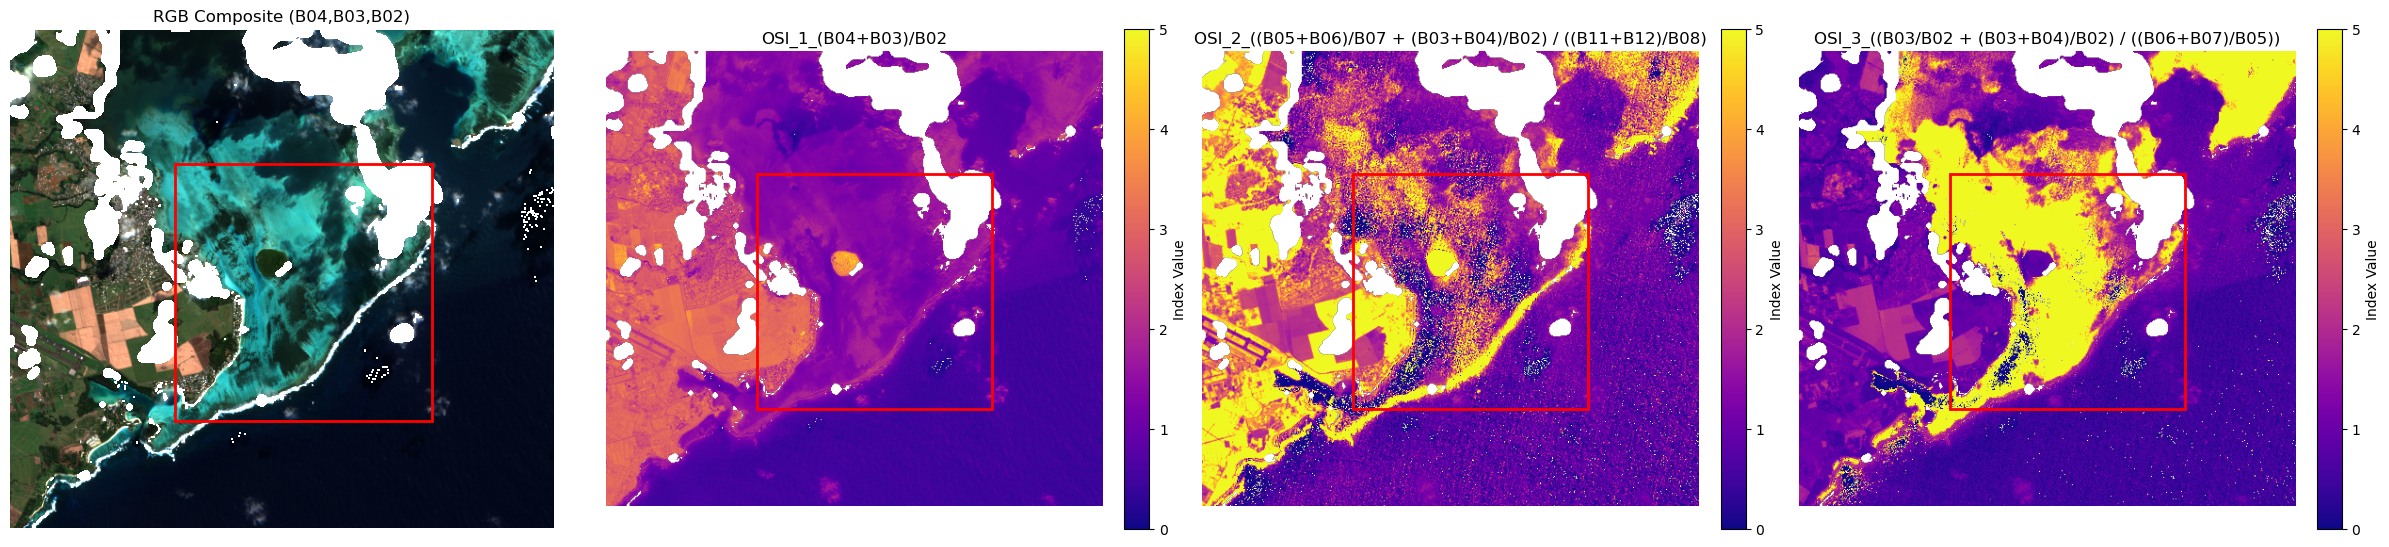

Displayed OSI variants for date: 2020-08-01T06:24:51.024000000


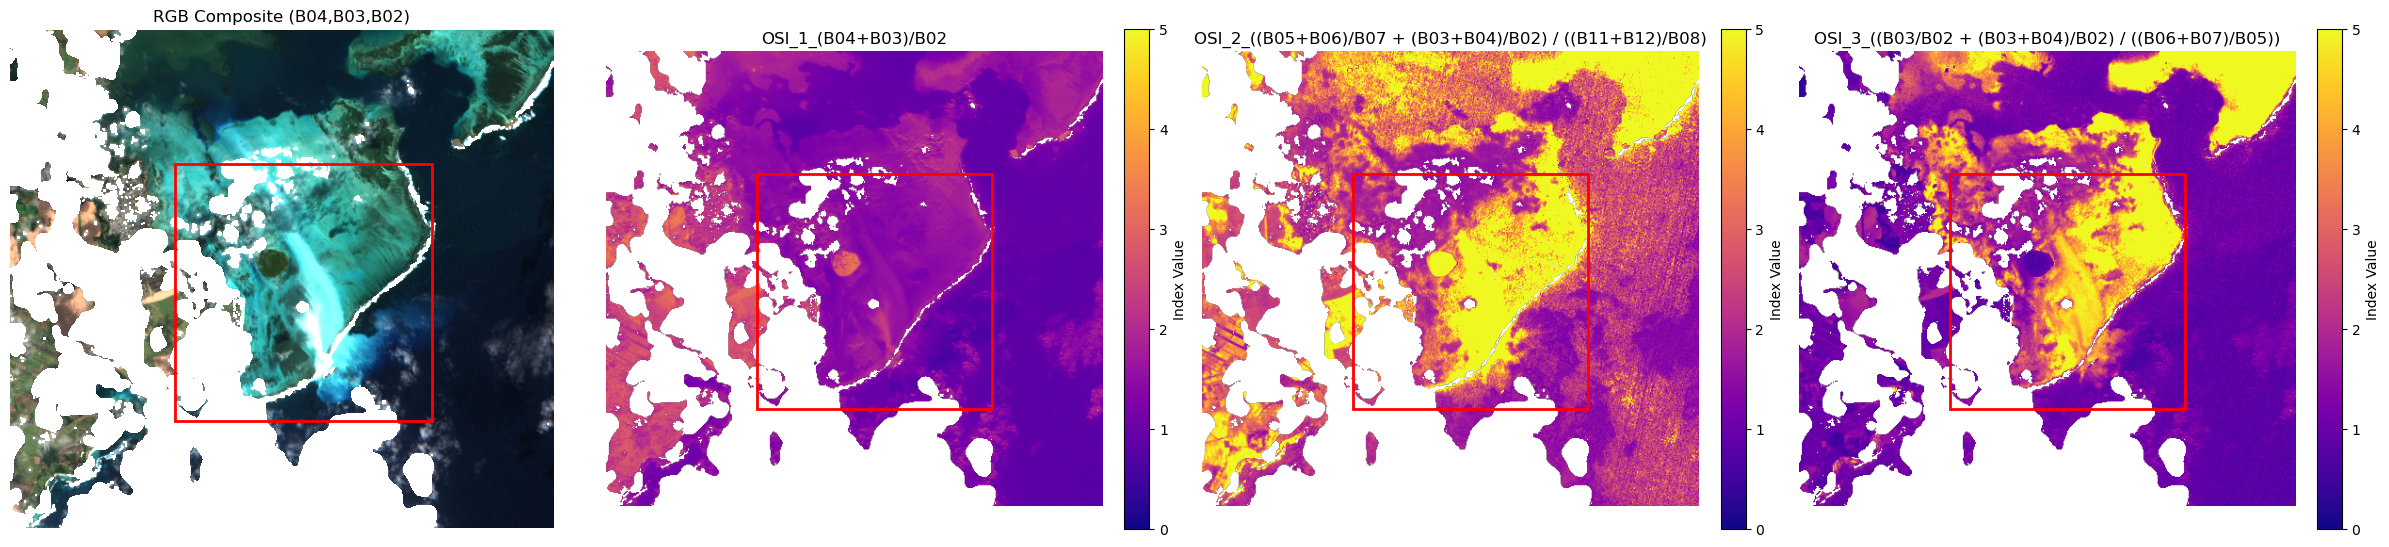

Displayed OSI variants for date: 2020-08-06T06:24:49.024000000


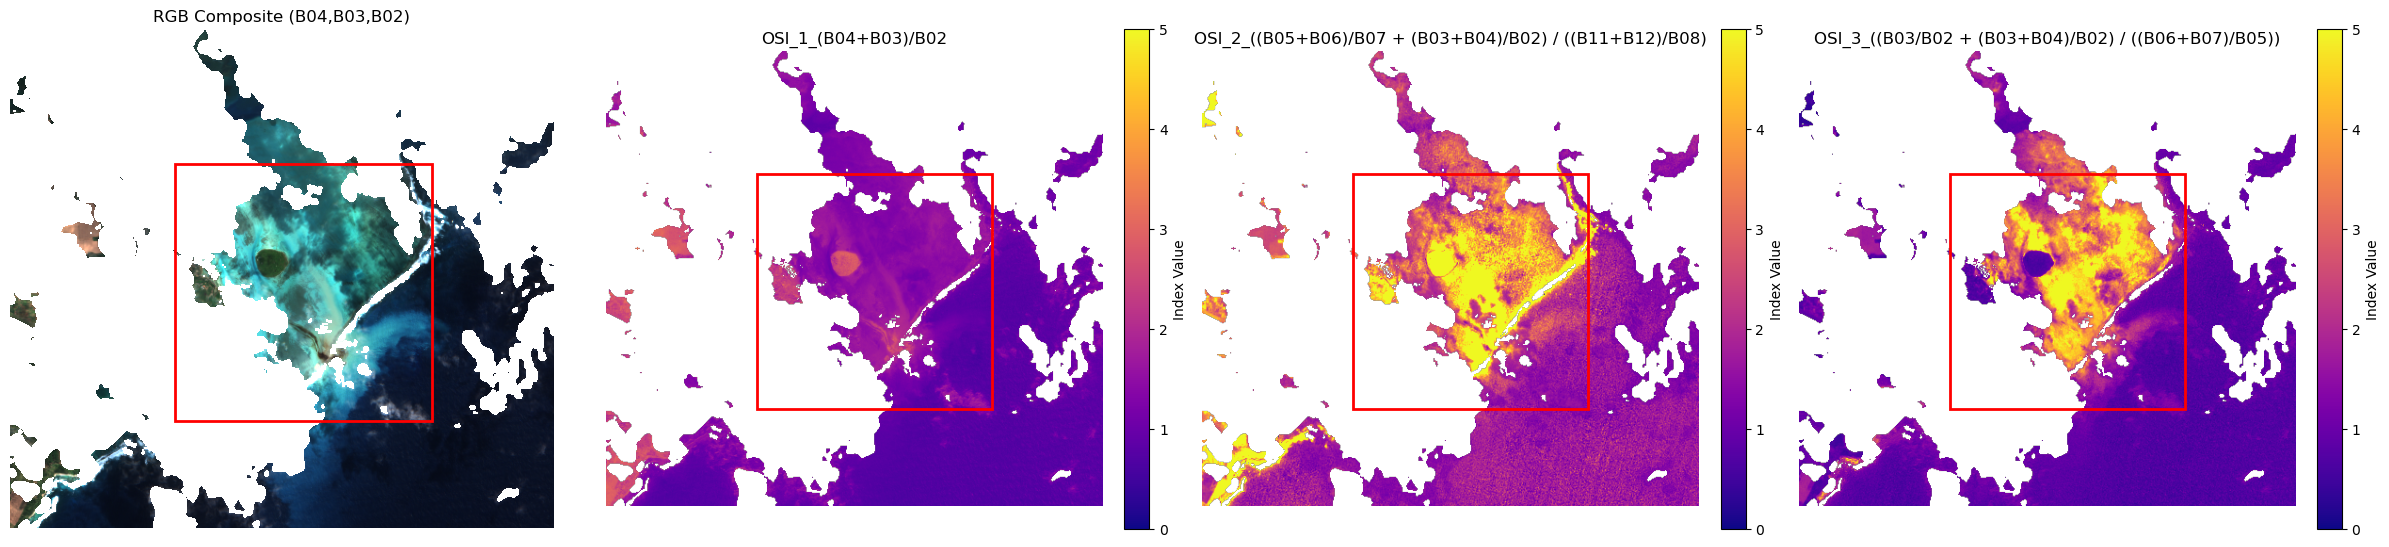

Displayed OSI variants for date: 2020-09-05T06:24:49.024000000


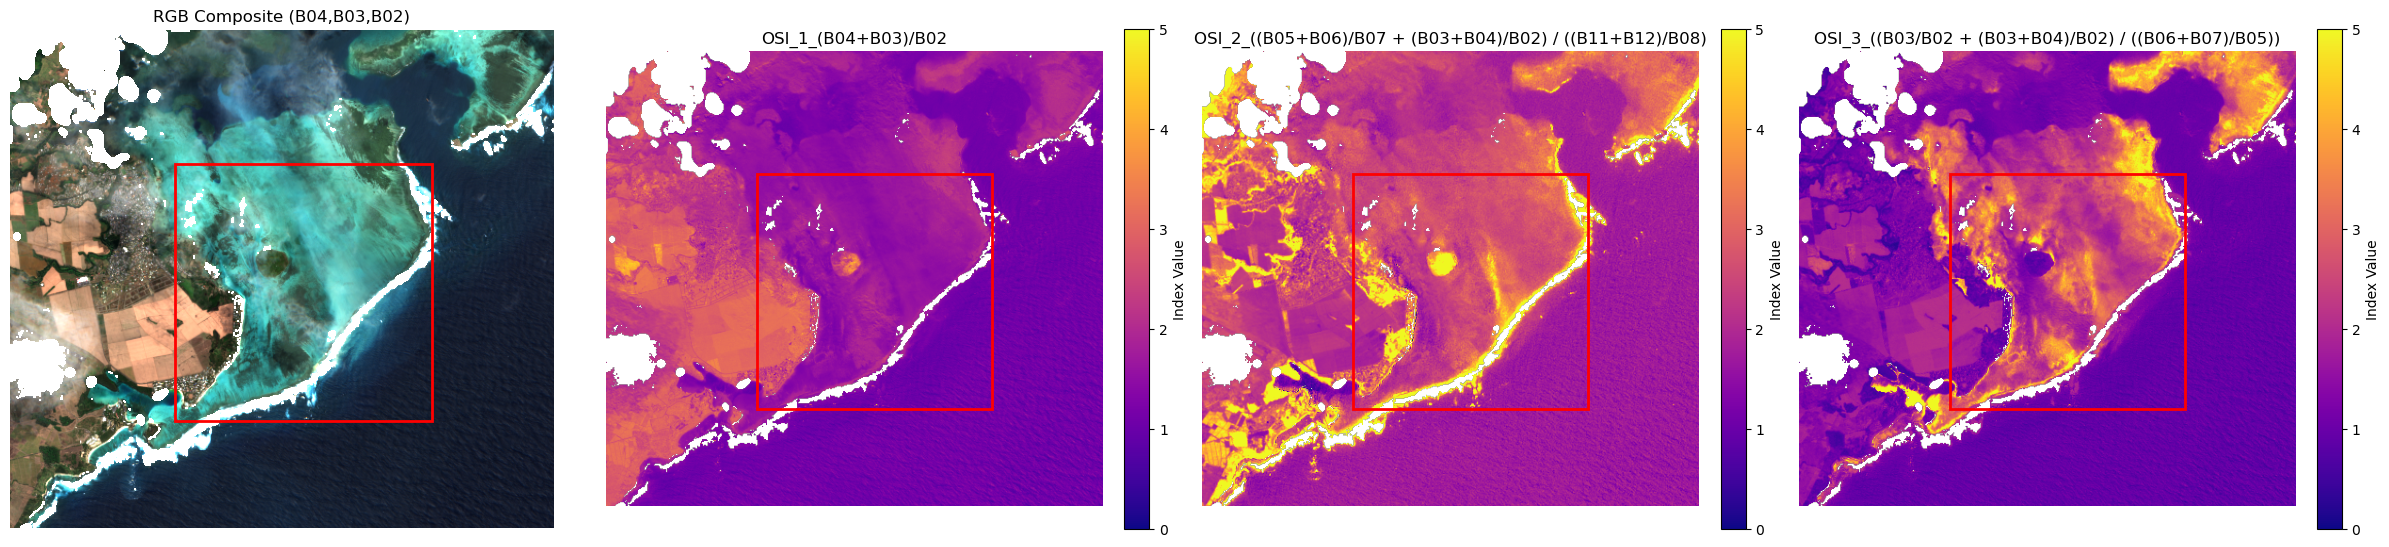

In [41]:
for i in range(4):
    ds = masked_datasets[i]
    print(f"Displayed OSI variants for date: {ds.time.values}")
    compute_osi_variants(ds, highlight_box=(160, 130, 250, 250))

In [42]:
# close the dask cluster
cluster.close()

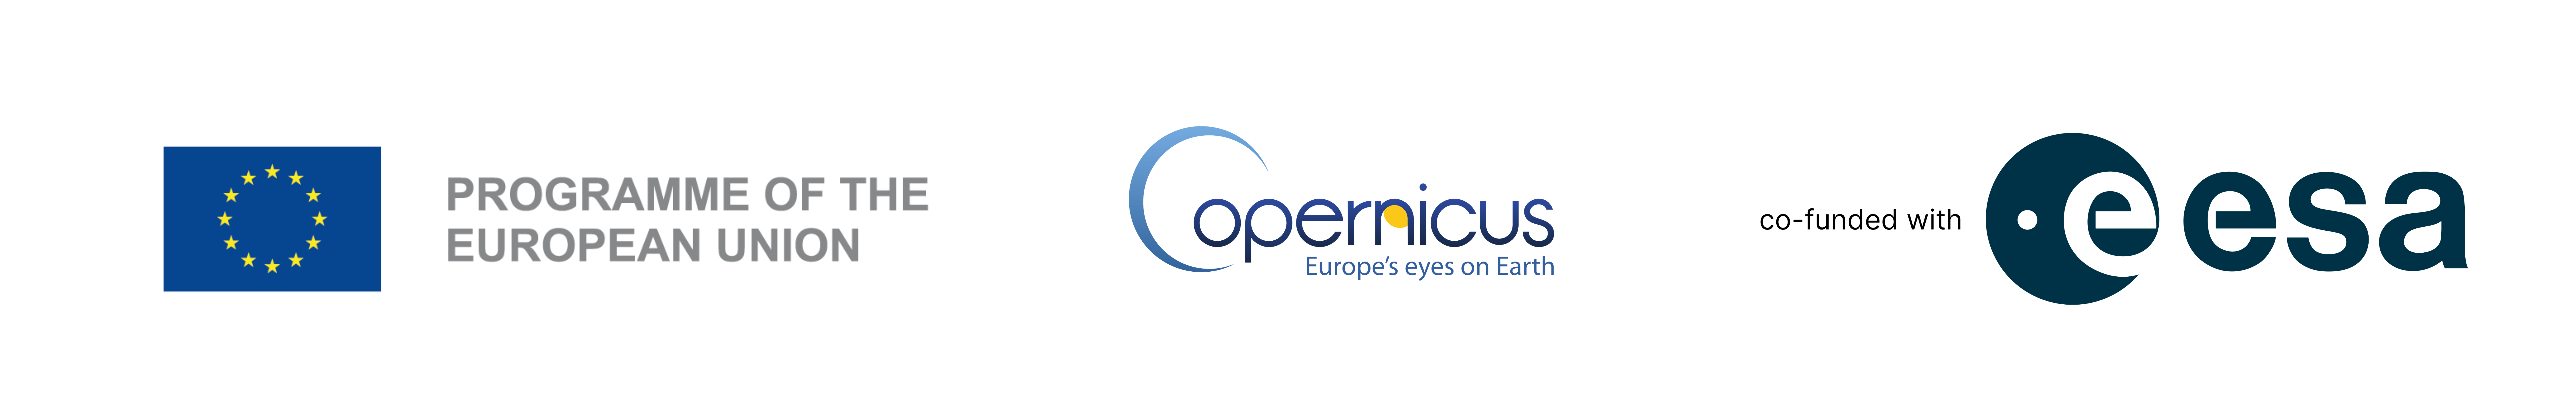